<a href="https://colab.research.google.com/github/bhardwaj1230/Deep-Learning-/blob/master/IFT6285_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation

* This notebook is used to solve Homework 3 of the course IFT6285. The problem statement can be found [here](http://www-labs.iro.umontreal.ca/~felipe/IFT6285-Automne2018/frontal.php?page=devoir3.html). We have two sets of sentences (english and french), and a set of labels indicating if a pair is related by translation. We have to build a classification algorithm based on this.

We first download the input files and pre-trained word embedding models.

In [0]:
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
!wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec
!wget http://www-labs.iro.umontreal.ca/~felipe/IFT6285-Automne2018/tps/tp3/tp3.tar.gz
!tar -zxvf tp3.tar.gz

--2019-03-21 19:59:15--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.28.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6.1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>]   6.14G  16.4MB/s    in 6m 24s  

2019-03-21 20:05:40 (16.4 MB/s) - ‘wiki.en.vec’ saved [6597238061/6597238061]

--2019-03-21 20:05:41--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.88
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3027096151 (2.8G) [binary/octet-stream]
Saving to: ‘wiki.fr.vec’

wiki.fr.vec         100%[===================>]   2

In [0]:
!ls 

Data_nobackup  sample_data  tp3.tar.gz	wiki.en.vec  wiki.fr.vec


We import some libraries.

In [0]:
import re
import codecs
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.optimizers import Adadelta
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Activation, Bidirectional, Lambda, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate, multiply, average, add, subtract 
from keras.layers import merge

Using TensorFlow backend.


We split the documents into words, and get the labels.

In [0]:
with open('./Data_nobackup/tp3-hardest/train.en') as f:
    train_en = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() for line in tqdm(f)]

with open('./Data_nobackup/tp3-hardest/train.fr') as f:
    train_fr = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() for line in tqdm(f)]

with open('./Data_nobackup/tp3-hardest/test.en') as f:
    test_en = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() for line in tqdm(f)]

with open('./Data_nobackup/tp3-hardest/test.fr') as f:
    test_fr = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() for line in tqdm(f)]

train_y = np.loadtxt('./Data_nobackup/tp3-hardest/train.y', dtype='int')
test_y = np.loadtxt('./Data_nobackup/tp3-hardest/test.y', dtype='int')

1038782it [00:05, 180532.18it/s]
1038782it [00:08, 129319.80it/s]
733789it [00:03, 185177.51it/s]
733789it [00:05, 133460.55it/s]


Create dictionaries of embeddings.

In [0]:
# code taken from 
# https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings

en_embeddings_index = {}
with codecs.open('wiki.en.vec', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        en_embeddings_index[word] = coefs

fr_embeddings_index = {}
with codecs.open('wiki.fr.vec', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        fr_embeddings_index[word] = coefs

2519428it [05:40, 7396.48it/s]
1152466it [02:38, 7251.96it/s]


Define the embedding dimension and sequence lengths for our model.

In [0]:
embed_dim = 300
max_seq_len = 40

We tokenize the documents, pad them so that they have the same length, create martrices of word embeddings according to the tokenized indices.

In [0]:
tokenizer_en = Tokenizer(lower=True, char_level=False)
tokenizer_en.fit_on_texts(train_en) 
word_seq_train_en = tokenizer_en.texts_to_sequences(train_en)
word_seq_test_en = tokenizer_en.texts_to_sequences(test_en)
word_index_en = tokenizer_en.word_index
#pad sequences
word_seq_train_en = pad_sequences(word_seq_train_en, maxlen=max_seq_len)
word_seq_test_en = pad_sequences(word_seq_test_en, maxlen=max_seq_len)

en_words_not_found = []
nb_words_en = len(word_index_en) + 1
en_embedding_matrix = np.zeros((nb_words_en, embed_dim))
for word, i in word_index_en.items():
    if i >= nb_words_en:
        continue
    embedding_vector = en_embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        en_embedding_matrix[i] = embedding_vector
    else:
        en_words_not_found.append(word)

In [0]:
tokenizer_fr = Tokenizer(lower=True, char_level=False)
tokenizer_fr.fit_on_texts(train_fr)
word_seq_train_fr = tokenizer_fr.texts_to_sequences(train_fr)
word_seq_test_fr = tokenizer_fr.texts_to_sequences(test_fr)
word_index_fr = tokenizer_fr.word_index
#pad sequences
word_seq_train_fr = pad_sequences(word_seq_train_fr, maxlen=max_seq_len)
word_seq_test_fr = pad_sequences(word_seq_test_fr, maxlen=max_seq_len)

fr_words_not_found = []
nb_words_fr = len(word_index_fr) + 1
fr_embedding_matrix = np.zeros((nb_words_fr, embed_dim))
for word, i in word_index_fr.items():
    if i >= nb_words_fr:
        continue
    embedding_vector = fr_embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        fr_embedding_matrix[i] = embedding_vector
    else:
        fr_words_not_found.append(word)

In [0]:
en_embedding_matrix.shape, fr_embedding_matrix.shape

((54401, 300), (87619, 300))

Create training and validation sets.

In [0]:
X_en_train, X_en_valid, X_fr_train, X_fr_valid, y_train, y_valid = \
    train_test_split(word_seq_train_en, word_seq_train_fr, train_y, test_size=0.3, stratify=train_y)

In [0]:
def add_noise(mat_a, mat_b, label, noise_ratio):
    n = mat_a.shape[0]
    ind1 = np.where(label == 1)[0]
    ind0 = np.where(label == 0)[0]
    if len(ind1) * noise_ratio <= len(ind0):
        return mat_a, mat_b, label
    while True:
        ind = np.random.randint(0, n, size=((noise_ratio+1)*len(ind1), 2))
        ind = np.unique(ind, axis=0)
        ne = np.where(ind[:, 0] != ind[:, 1])[0][:(noise_ratio*len(ind1)-len(ind0))]
        if ne.shape[0] == noise_ratio*len(ind1)-len(ind0): break
    ind = ind[ne]
    mat_a_fake = mat_a[ind[:, 0]]
    mat_b_fake = mat_b[ind[:, 1]]
    mat_a_aug = np.vstack([mat_a, mat_a_fake])
    mat_b_aug = np.vstack([mat_b, mat_b_fake])
    label_aug = np.hstack([label, np.zeros(noise_ratio*len(ind1)-len(ind0), dtype='int')])
    return mat_a_aug, mat_b_aug, label_aug

  
word_seq_train_en_aug, word_seq_train_fr_aug, train_y_aug = \
    add_noise(word_seq_train_en, word_seq_train_fr, train_y, noise_ratio=20)
X_en_train, X_en_valid, X_fr_train, X_fr_valid, y_train, y_valid = \
    train_test_split(word_seq_train_en_aug, word_seq_train_fr_aug, train_y_aug, test_size=0.3, stratify=train_y_aug)

### Base Model

For our base model, we take the average of the English and French word embeddings and pass it through two dense hidden layers with sigmoid activation functions. After 30 epochs, this model achieves 90% validation accuracy.

In [0]:
input_en = Input(shape=(max_seq_len, ), name='en')
input_fr = Input(shape=(max_seq_len, ), name='fr')
#Embedding layers
emb_en = Embedding(nb_words_en, embed_dim, weights=[en_embedding_matrix], input_length=(max_seq_len, ), trainable=False)(input_en)
emb_fr = Embedding(nb_words_fr, embed_dim, weights=[fr_embedding_matrix], input_length=(max_seq_len, ), trainable=False)(input_fr)
emb_mean = average([emb_en, emb_fr])
dense = Dense(150, activation='sigmoid')(emb_mean)
flt = Flatten()(dense)
output = Dense(1, activation='sigmoid')(flt)
base_model = Model(inputs=[input_en, input_fr], outputs=output)
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
base_model.fit([X_en_train, X_fr_train], y_train, batch_size=300, epochs=10, validation_data=([X_en_valid, X_fr_valid], y_valid), verbose=1)

Train on 6851640 samples, validate on 2936418 samples
Epoch 1/10
6851640/6851640 [==============================] - 926s 135us/step - loss: 0.1180 - acc: 0.9629 - val_loss: 0.0821 - val_acc: 0.9738
Epoch 2/10
1651500/6851640 [======>.......................] - ETA: 8:58 - loss: 0.0792 - acc: 0.9746

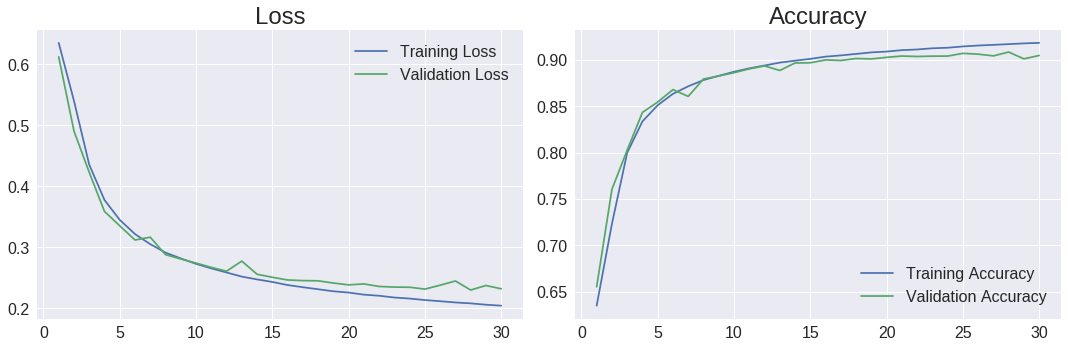

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(range(1, 31), base_model.history.history['loss'], label='Training Loss')
plt.plot(range(1, 31), base_model.history.history['val_loss'], label='Validation Loss')
plt.legend(prop={'size':16})
plt.title("Loss", fontsize=24)
plt.subplot(1, 2, 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(range(1, 31), base_model.history.history['acc'], label='Training Accuracy')
plt.plot(range(1, 31), base_model.history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc=4, prop={'size':16})
plt.title("Accuracy", fontsize=24)
plt.tight_layout()

### Main Model

We use bidirectional LSTMs with dropouts for our main model. After creating separate representations for english and french words, we take their absolute difference and elementwise product, take their sum, and pass it through two dense hidden layers. We see this improves significantly upon our base model accuracy.

In [0]:
def abs_diff(l):
    ''' Helper function for the similarity estimate of the LSTMs outputs '''
    return K.abs(subtract(l))

In [0]:
#Placeholders
input_en = Input(shape=(max_seq_len, ), name='en')
input_fr = Input(shape=(max_seq_len, ), name='fr')
#Embedding layers
emb_en = Embedding(nb_words_en, embed_dim, weights=[en_embedding_matrix], 
                   input_length=(max_seq_len, ), trainable=False)(input_en)
emb_fr = Embedding(nb_words_fr, embed_dim, weights=[fr_embedding_matrix], 
                   input_length=(max_seq_len, ), trainable=False)(input_fr)
#LSTM layers
lstm_en = Bidirectional(LSTM(embed_dim, dropout=0.2, 
                             recurrent_dropout=0.3, 
                             return_sequences=False))(emb_en)
lstm_fr = Bidirectional(LSTM(embed_dim, dropout=0.2, 
                             recurrent_dropout=0.3, 
                             return_sequences=False))(emb_fr)
#Absolute difference
elem_diff = Lambda(abs_diff)([lstm_en, lstm_fr])
#Elementwise product
elem_prod = multiply([lstm_en, lstm_fr])
#Feedforward and add
dense1 = Dense(150, use_bias=False)(elem_diff)
dense2 = Dense(150, use_bias=False)(elem_prod)
dense_sum = add([dense1, dense2])
dense_out = Dense(75, activation='tanh')(dense_sum)
output = Dense(1, activation='sigmoid')(dense_out)
model = Model(inputs=[input_en, input_fr], outputs=output)
opt = Adadelta(clipnorm=5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#model.fit([X_en_train, X_fr_train], y_train, batch_size=300, epochs=10,
#          validation_data=([X_en_valid, X_fr_valid], y_valid), verbose=1)
model.fit([word_seq_train_en, word_seq_train_fr], train_y, batch_size=300, epochs=1, verbose=1)

Epoch 1/1
1038782/1038782 [==============================] - 1498s 1ms/step - loss: 0.1729 - acc: 0.9270


In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


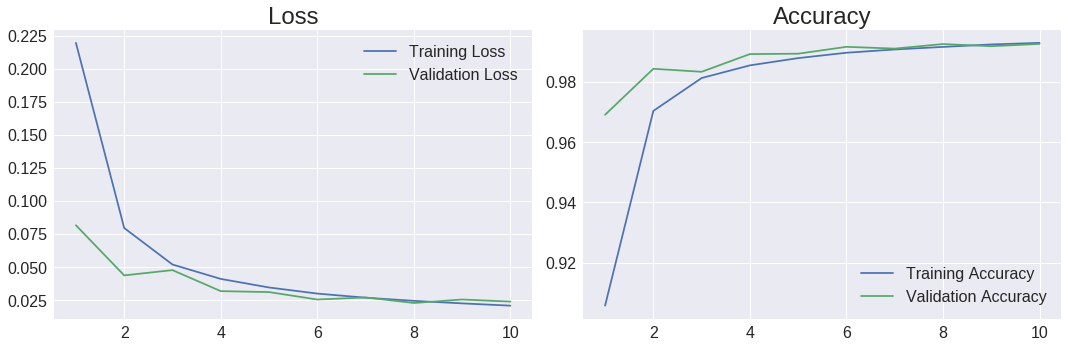

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(range(1, 11), model.history.history['loss'], label='Training Loss')
plt.plot(range(1, 11), model.history.history['val_loss'], label='Validation Loss')
plt.legend(loc=1, prop={'size':16})
plt.title("Loss", fontsize=24)
plt.subplot(1, 2, 2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(range(1, 11), model.history.history['acc'], label='Training Accuracy')
plt.plot(range(1, 11), model.history.history['val_acc'], label='Validation Accuracy')
plt.title("Accuracy", fontsize=24)
plt.legend(loc=4, prop={'size':16})
plt.tight_layout()

We pick a threshold that maximizes the F1 score on the validation set, and use that threshold to calculate the F1 score on the test set.

In [0]:
probs = model.predict([word_seq_test_en, word_seq_test_fr], verbose=1, batch_size=2000).ravel()
d = {}
for t in np.linspace(0, 0.99, 100):
    pred_y = (probs > t) * 1
    d[f1_score(test_y, pred_y)] = t
print(d[max(d)], max(d))

thres = d[max(d)]

733789/733789 [==============================] - 210s 286us/step
0.6900000000000001 0.9751603484623108


In [0]:
!wget http://www-labs.iro.umontreal.ca/~felipe/IFT6285-Automne2018/tps/test.tar.gz
!tar -zxvf test.tar.gz

with open('test.en') as f:
    test__en = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() for line in tqdm(f)]

with open('test.fr') as f:
    test__fr = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() for line in tqdm(f)]

word_seq_test__en = tokenizer_en.texts_to_sequences(test__en)
word_seq_test__en = pad_sequences(word_seq_test__en, maxlen=max_seq_len)

word_seq_test__fr = tokenizer_fr.texts_to_sequences(test__fr)
word_seq_test__fr = pad_sequences(word_seq_test__fr, maxlen=max_seq_len)

probs = model.predict([word_seq_test__en, word_seq_test__fr], verbose=1, batch_size=2000).ravel()
pred_y = (probs > thres) * 1

print(np.sum(pred_y))

print(pred_y)

--2019-01-05 22:32:36--  http://www-labs.iro.umontreal.ca/~felipe/IFT6285-Automne2018/tps/test.tar.gz
Resolving www-labs.iro.umontreal.ca (www-labs.iro.umontreal.ca)... 132.204.26.154
Connecting to www-labs.iro.umontreal.ca (www-labs.iro.umontreal.ca)|132.204.26.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366422 (358K) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 357.83K   652KB/s    in 0.5s    

2019-01-05 22:32:37 (652 KB/s) - ‘test.tar.gz’ saved [366422/366422]

./test.fr
./test.en


4500it [00:00, 195146.43it/s]
4500it [00:00, 158356.63it/s]


4500/4500 [==============================] - 1s 309us/step
3846
[1 1 1 ... 1 1 1]


In [0]:
np.savetxt("pred.y", pred_y, delimiter=",", fmt="%d")

In [0]:
print(pred_y.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

In [0]:
# TODO: Check the effect of added noise in the training set

In [0]:
def add_noise(mat_a, mat_b, label, noise_ratio):
    n = mat_a.shape[0]
    ind1 = np.where(label == 1)[0]
    ind0 = np.where(label == 0)[0]
    if len(ind1) * noise_ratio <= len(ind0):
        return mat_a, mat_b, label
    while True:
        ind = np.random.randint(0, n, size=((noise_ratio+1)*len(ind1), 2))
        ind = np.unique(ind, axis=0)
        ne = np.where(ind[:, 0] != ind[:, 1])[0][:(noise_ratio*len(ind1)-len(ind0))]
        if ne.shape[0] == noise_ratio*len(ind1)-len(ind0): break
    ind = ind[ne]
    mat_a_fake = mat_a[ind[:, 0]]
    mat_b_fake = mat_b[ind[:, 1]]
    mat_a_aug = np.vstack([mat_a, mat_a_fake])
    mat_b_aug = np.vstack([mat_b, mat_b_fake])
    label_aug = np.hstack([label, np.zeros(noise_ratio*len(ind1)-len(ind0), dtype='int')])
    return mat_a_aug, mat_b_aug, label_aug

In [0]:
mat_a = np.arange(1, 10).reshape((3, -1))
mat_b = np.arange(10, 19).reshape((3, -1))
label = np.array([1, 1, 0])
noise_ratio = 3

In [0]:
a, b, c = add_noise(mat_a, mat_b, label, noise_ratio)

In [0]:
np.hstack([a, b])

array([[ 1,  2,  3, 10, 11, 12],
       [ 4,  5,  6, 13, 14, 15],
       [ 7,  8,  9, 16, 17, 18],
       [ 1,  2,  3, 13, 14, 15],
       [ 1,  2,  3, 16, 17, 18],
       [ 4,  5,  6, 10, 11, 12],
       [ 4,  5,  6, 16, 17, 18],
       [ 7,  8,  9, 13, 14, 15]])

In [0]:
c

array([1, 1, 0, 0, 0, 0, 0, 0])

In [0]:
word_seq_train_en_aug, word_seq_train_fr_aug, train_y_aug = \
    add_noise(word_seq_train_en, word_seq_train_fr, train_y, noise_ratio=5)
X_en_train, X_en_valid, X_fr_train, X_fr_valid, y_train, y_valid = \
    train_test_split(word_seq_train_en_aug, word_seq_train_fr_aug, train_y_aug, test_size=0.3, stratify=train_y_aug)

In [0]:
#Placeholders
input_en = Input(shape=(max_seq_len, ), name='en')
input_fr = Input(shape=(max_seq_len, ), name='fr')
#Embedding layers
emb_en = Embedding(nb_words_en, embed_dim, weights=[en_embedding_matrix], 
                   input_length=(max_seq_len, ), trainable=False)(input_en)
emb_fr = Embedding(nb_words_fr, embed_dim, weights=[fr_embedding_matrix], 
                   input_length=(max_seq_len, ), trainable=False)(input_fr)
#LSTM layers
lstm_en = Bidirectional(LSTM(embed_dim, dropout=0.2, 
                             recurrent_dropout=0.3, 
                             return_sequences=False))(emb_en)
lstm_fr = Bidirectional(LSTM(embed_dim, dropout=0.2, 
                             recurrent_dropout=0.3, 
                             return_sequences=False))(emb_fr)
#Absolute difference
elem_diff = Lambda(abs_diff)([lstm_en, lstm_fr])
#Elementwise product
elem_prod = multiply([lstm_en, lstm_fr])
#Feedforward and add
dense1 = Dense(150, use_bias=False)(elem_diff)
dense2 = Dense(150, use_bias=False)(elem_prod)
dense_sum = add([dense1, dense2])
dense_out = Dense(75, activation='tanh')(dense_sum)
output = Dense(1, activation='sigmoid')(dense_out)
model = Model(inputs=[input_en, input_fr], outputs=output)
opt = Adadelta(clipnorm=5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit([X_en_train, X_fr_train], y_train, batch_size=300, epochs=4,
          validation_data=([X_en_valid, X_fr_valid], y_valid), verbose=1)

Train on 1957611 samples, validate on 838977 samples
Epoch 1/4
1957611/1957611 [==============================] - 3907s 2ms/step - loss: 0.0925 - acc: 0.9638 - val_loss: 0.0298 - val_acc: 0.9894
Epoch 2/4
1957611/1957611 [==============================] - 3867s 2ms/step - loss: 0.0329 - acc: 0.9881 - val_loss: 0.0225 - val_acc: 0.9921
Epoch 3/4
1957611/1957611 [==============================] - 3724s 2ms/step - loss: 0.0236 - acc: 0.9917 - val_loss: 0.0149 - val_acc: 0.9949
Epoch 4/4
1957611/1957611 [==============================] - 3640s 2ms/step - loss: 0.0191 - acc: 0.9933 - val_loss: 0.0131 - val_acc: 0.9956


In [0]:
probs = model.predict([X_en_valid, X_fr_valid], verbose=1, batch_size=2000).ravel()
d = {}
for t in np.linspace(0, 0.99, 100):
    y_pred = (probs > t) * 1
    d[f1_score(y_valid, y_pred)] = t
print(d[max(d)], max(d))

838977/838977 [==============================] - 230s 274us/step
0.59 0.9872296549822962


In [0]:
probs = model.predict([word_seq_test_en, word_seq_test_fr], verbose=1, batch_size=2000).ravel()
pred_y = (probs > 0.59) * 1
print(f1_score(test_y, pred_y))

733789/733789 [==============================] - 201s 273us/step
0.9871111585524446


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)
print(cm)
